# Lattice model

This notebook simulates the evolution of a three-species system with local dispersal. All lattice-based model were developed using the [Mesa](https://mesa.readthedocs.io/en/stable/) framework.

Importing the necessary libraries:

In [1]:
import solara
import mesa
import numpy as np
import pandas as pd
from matplotlib.figure import Figure
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from mesa.experimental import JupyterViz
from lattice_models.model_rand_act import RSPRandAct
%matplotlib inline

/Users/irenetesta/anaconda3/envs/stochpy/lib/python3.11/site-packages/solara/validate_hooks.py:122: UserWarning: /Users/irenetesta/anaconda3/envs/stochpy/lib/python3.11/site-packages/mesa/experimental/jupyter_viz.py:163: JupyterViz: `use_state` found within a nested function created on line 155
To suppress this check, replace the line with:
        grid_layout, set_grid_layout = solara.use_state(grid_layout_initial)  # noqa: SH104

Make sure you understand the consequences of this, by reading about the rules of hooks at:
    https://solara.dev/documentation/advanced/understanding/rules-of-hooks

  warnings.warn(str(e))


## Random activation of agents

In this model the N sites are taken to be sites in a periodic, square lattice and, at each time-step, the second individual is randomly chosen to be one of the eight neighbors of the first.

### Implementation details

The model is defined by the class `RSPRandAct` in the file `./lattice_models/model_rand_act.py`:

In [2]:
%pycat ./lattice_models/model_rand_act.py

import mesa
from .patch_rand_act import PatchRandAct
from mesa.datacollection import DataCollector

class RSPRandAct(mesa.Model):
    """
    A system with three species in a competitive loop: a rock beats a pair of scissors,
    scissors beat a sheet of paper and paper beats a rock.
    """

    # key: species, value: list of species that the key species can beat
    # e.g. ROCK (0) beats SCISSOR (1), SCISSOR (1) beats PAPER (2), PAPER (2) beats ROCK (0)
    rules3 = {0: [1], 1: [2], 2: [0]}
    rules4 = {0: [1], 1: [2], 2: [3], 3: [0]}
    rules5 = {0: [1,2], 1: [2,3], 2: [3,4], 3: [4,0], 4: [0,1]}

    def __init__(self,
                 init0, init1, init2, init3, init4,
                 invrate0, invrate1, invrate2, invrate3, invrate4,
                 n_species,
                 color_map,
                 increase_rate=False,
                 width=50, height=50):
        """
        Create a new playing area of (width, height) patches.
        """
        super().__init__()

  

- The model can be simulated with 3, 4, or 5 species.
- Each agent is activated once per step, in random order, with the order reshuffled each step, through the `RandomActivation` scheduler.
- Agents are situated on a rectangular, periodic grid (i.e. torus), where each cell contains exactly at most one agent. Such a grid is created by the `mesa.space.SingleGrid` class.
- The grid is randomly initialized by placing agents in each cell according to the initial proportions of the species.

The behavior of each agent (grid patch) is defined by the class `PatchRandAct` in the file `./lattice_models/patch_rand_act.py`:

In [3]:
%pycat ./lattice_models/patch_rand_act.py

import mesa

class PatchRandAct(mesa.Agent):
    """Represents a single patch in the simulation."""

    def __init__(self, pos, model, init_state):
        """
        Create a patch, in the given state, at the given x, y position.
        """
        super().__init__(pos, model)
        self.rules = model.rules
        self.n_species = model.n_species
        self.color_map = model.color_map
        self.x, self.y = pos
        self.state = init_state
        self._nextState = None

    def step(self):
        """
        Compute if the patch will be rock, scissors or paper at the next tick.  This is
        based on the number of rock, scissors and paper in the neighborhood.
        The state is not changed here, but is just computed and stored in self._nextState,
        because our current state may still be necessary for our neighbors
        to calculate their next state.
        """
        # Get the neighbors
        neighbors = self.model.grid.get_neighbors((self.x, self.y), 

- Each patch has a Moore neighborhood, i.e. the eight cells surrounding it.
- At each step, a neighbor is randomly chosen and the agent in the patch interacts with it. According to the invasion rates, the neighboring agent may be defeated and may become the same species as the agent in the patch.
- If the parameter `increase_rate` is set to `True`, after 100 steps the invasion rate of species 0 is increased whenever it replicates onto a new site. The increment is a random number uniformly distributed between 0 and 1e-4 and the new invasion rate is accepted if it is in the range $0<P_r<1$).

### Simulations

Defining functions to visualize the evolution of the system:

In [35]:
def agent_portrayal(cell):
    '''
    This function defines the appearance of the agents in the visualization.
    '''
    return {"color": cell.color_map[cell.state], "marker": "s", "size": 1}

def draw_grid(grid, agent_portrayal, title=None):
    '''
    This function draws the lattice grid.
    '''
    def portray(g):
        x = []
        y = []
        s = []  # size
        c = []  # color
        for i in range(g.width):
            for j in range(g.height):
                content = g._grid[i][j]
                if not content:
                    continue
                if not hasattr(content, "__iter__"):
                    # Is a single grid
                    content = [content]
                for agent in content:
                    data = agent_portrayal(agent)
                    x.append(i)
                    y.append(j)
                    if "size" in data:
                        s.append(data["size"])
                    if "color" in data:
                        c.append(data["color"])
        out = {"x": x, "y": y}
        # This is the default value for the marker size, which auto-scales
        # according to the grid area.
        out["s"] = (180 / max(g.width, g.height)) ** 2
        if len(s) > 0:
            out["s"] = s
        if len(c) > 0:
            out["c"] = c
        return out

    space_fig = Figure()
    space_ax = space_fig.subplots()
    space_ax.set_xlim(-1, grid.width)
    space_ax.set_ylim(-1, grid.height)
    space_ax.scatter(**portray(grid))
    space_ax.set_title(title)
    return space_fig

def line_plot(model, title=None):
    '''
    This function plots the fraction of individuals of each type over time.
    '''
    fig = Figure()
    ax = fig.subplots()
    model_data = model.datacollector.get_model_vars_dataframe()
    tot_individuals =model_data[0] + model_data[1] + model_data[2]
    model_data[0] = model_data[0] / tot_individuals
    model_data[1] = model_data[1] / tot_individuals
    model_data[2] = model_data[2] / tot_individuals
    model_data[[0, 1, 2]].plot(ax=ax, style='-o', color=['tab:red', 'purple', 'gold'])
    ax.legend(['$n_r$', '$n_s$', '$n_p$'])
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Fraction of Individuals')
    ax.set_title(title)
    solara.FigureMatplotlib(fig)
    return fig

def plot_rate_species0(model, title=None):
    '''
    This function plots the invasion rate of species 0 over time as well as the fraction of individuals of species 0.
    '''
    fig = Figure()
    ax = fig.subplots()
    model_data = model.datacollector.get_model_vars_dataframe()
    tot_individuals = model_data[0] + model_data[1] + model_data[2]
    model_data[0] = model_data[0] / tot_individuals
    model_data[[0, 'increased_rate']].plot(ax=ax, style='-o', color=['tab:red', 'black'])
    ax.legend(['$n_r$', '$P_r$'])
    ax.set_xlabel('Time Step')
    ax.set_title(title)
    solara.FigureMatplotlib(fig)
    return fig

def ternary_plot_species_evolution(df, title=None, show_markers=True):
    '''
    Plot the evolution of species proportions over time in a ternary plot.
    
    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    '''
    fig = px.scatter_ternary(
        df,
        a=df.columns[2],
        b=df.columns[0],
        c=df.columns[1],
        color=df.index,
        color_continuous_scale='blues',
        size_max=10,
        title=title
    )
    fig.update_layout(
        width=750,
    )
    if show_markers:
        fig.update_traces(mode='lines+markers', line=dict(color='black', width=1),
            marker=dict(symbol='circle', line=dict(width=1, color='black')))
    else:
        fig.update_traces(mode='lines', line=dict(color='black', width=1))
    fig.update_layout(coloraxis_colorbar=dict(title='Time'))
    fig.show('png')

Let's define the parameters to perform a simulation of a system with 3 species, on a square lattice with $N=200\cdot 200$ sites and invasion rates $P_r=0.2, P_s=0.5, P_p=0.3$. The grid will be initialized with the sites being randomly assigned to one of the three species ($n_r=0.33, n_s=0.33, n_p=0.33$). In all the simulations, species R will be represented in red, species S in purple and species P in yellow.

In [5]:
color_map = {
    0: 'red',
    1: 'purple',
    2: 'yellow',
}
model_params1 = {
    "height": 200,
    "width": 200,
    "n_species": 3,
    "init0": 0.33,
    "init1": 0.33,
    "init2": 0.33,
    "init3": 0,
    "init4": 0,
    "invrate0": 0.2,
    "invrate1": 0.5,
    "invrate2": 0.3,
    "invrate3": 0,
    "invrate4": 0,
    "color_map": color_map
}

Running the simulation for 300 steps:

In [6]:
model1 = RSPRandAct(**model_params1)
for i in range(300):
    model1.step()
results_df = model1.datacollector.get_model_vars_dataframe().rename(columns={0: '$n_r$', 1: '$n_s$', 2: '$n_p$'})

Defining a function to build the title for the plots using the model's parameters:

In [7]:
def build_title(params, steps):
    '''
    This function builds the title for the plots using the parameters of the model.
    '''
    title = f"$N={params['height']}\times{params['width']},"\
    f" n_r^0={params['init0']}, n_s^0={params['init1']}, n_p^0={params['init2']},"\
    f"P_r={params['invrate0']}, P_s={params['invrate1']}, P_p={params['invrate2']}, steps={steps}$"
    return title

Plotting the evolution of the system:

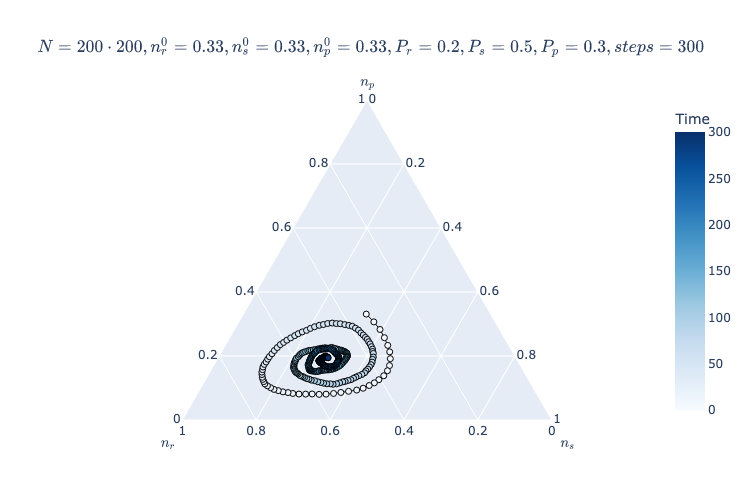

In [8]:
ternary_plot_species_evolution(results_df, title=build_title(params=model_params1, steps=300))

Unlike the long-range dispersal model, where the weakest species outcompetes the others in the same setting, here the dynamics stabilize, and the population densities converge towards a fixed point.

Let's define the parameters to perform a simulation of a system with 3 species, on a square lattice with $N=200\cdot 200$ sites and equal invasion rates ($Pr_=0.33, P_s=0.33, P_p=0.33$). The grid will be initialized with the sites being randomly assigned to each of the three species in fixed-point proportions ($n_r=0.33, n_s=0.33, n_p=0.33$).

In [9]:
model_params2 = {
    "height": 200,
    "width": 200,
    "n_species": 3,
    "init0": 0.33,
    "init1": 0.33,
    "init2": 0.33,
    "init3": 0,
    "init4": 0,
    "invrate0": 0.33,
    "invrate1": 0.33,
    "invrate2": 0.33,
    "invrate3": 0,
    "invrate4": 0,
    "color_map": color_map
}

Creating the widget to interactively simulate the system:

In [10]:
page = JupyterViz(
    RSPRandAct,
    model_params2,
    measures=[line_plot],
    agent_portrayal=agent_portrayal,
)
page

Cannot show ipywidgets in text

Since the widget cannot be saved in the notebook, let's run a simulation on a square lattice with $N=500\cdot 500$ sites and plot the grid after 100 steps and the evolution of the species proportions over time.

In [11]:
model2 = RSPRandAct(**model_params2)
for i in range(100):
    model2.step()

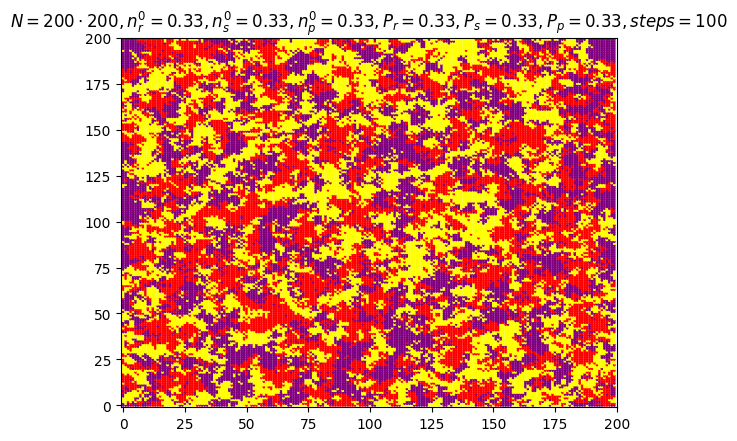

In [12]:
draw_grid(
    model2.grid,
    agent_portrayal,
    title=build_title(params=model_params2, steps=100)
)

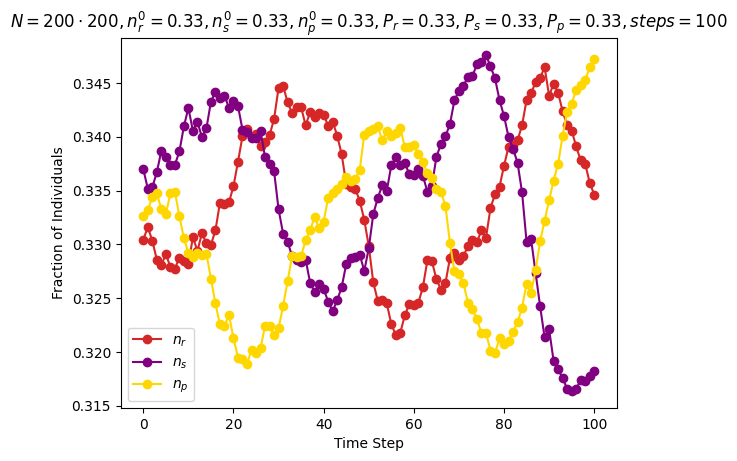

In [13]:
line_plot(
    model2,
    title=build_title(params=model_params2, steps=100)
)

With equal invasion rates the populations form clumps.

Let's define the parameters to perform a simulation of a system with 3 species, on a square lattice with $N=200\cdot 200$ sites and invasion rates $P_r=0.1, P_s=0.1, P_p=0.8$. The grid is initialized with the sites being randomly assigned to each of the three species in fixed-point proportions ($n_r=0.1, n_s=0.8, n_p=0.1$).

In [14]:
model_params3 = {
    "height": 200,
    "width": 200,
    "color_map": color_map,
    "n_species": 3,
    "init0": 0.1,
    "init1": 0.8,
    "init2": 0.1,
    "init3": 0,
    "init4": 0,
    "invrate0": 0.1,
    "invrate1": 0.1,
    "invrate2": 0.8,
    "invrate3": 0,
    "invrate4": 0,
}

Creating the widget to interactively simulate the system:

In [15]:
page = JupyterViz(
    RSPRandAct,
    model_params3,
    measures=[line_plot],
    agent_portrayal=agent_portrayal,
)
page

Cannot show ipywidgets in text

Running a simulation and plotting the grid after 100 steps and the evolution of the species proportions over time.

In [16]:
model3 = RSPRandAct(**model_params3)
for i in range(100):
    model3.step()

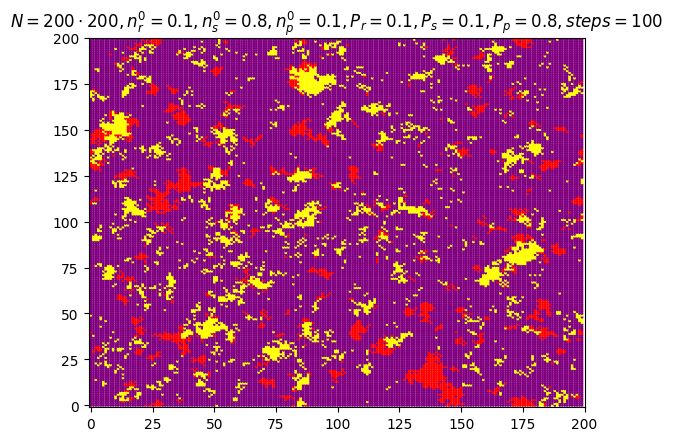

In [17]:
draw_grid(
    model3.grid,
    agent_portrayal,
    title=build_title(params=model_params3, steps=100)
)

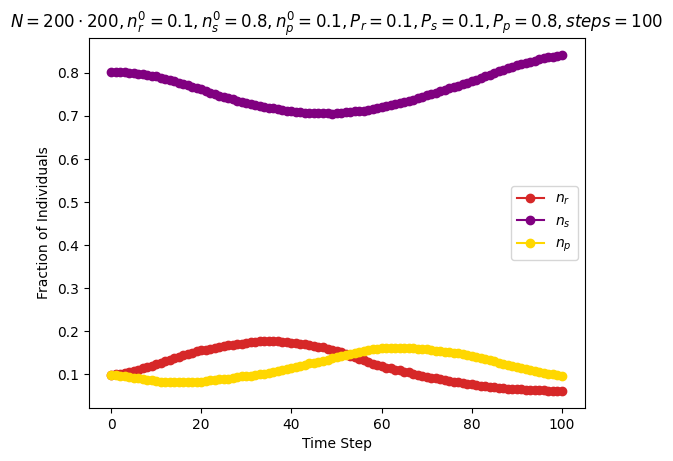

In [18]:
line_plot(
    model3,
    title=build_title(params=model_params3, steps=100)
)

When species S invasion rates is much larger than the other two, species R and P form disconnected islands amongst species S.

Let's define the parameters to perform a simulation of a system with 3 species, on a square lattice with $N=200\cdot 200$ sites and invasion rates $P_r=0.05, P_s=0.475, P_p=0.475$. The grid is initialized with the sites being randomly assigned to each of the three species in fixed-point proportions ($n_r=0.475, n_s=0.475, n_p=0.05$).

In [19]:
model_params4 = {
    "height": 200,
    "width": 200,
    "color_map": color_map,
    "n_species": 3,
    "init0": 0.475,
    "init1": 0.475,
    "init2": 0.05,
    "init3": 0,
    "init4": 0,
    "invrate0": 0.05,
    "invrate1": 0.475,
    "invrate2": 0.475,
    "invrate3": 0,
    "invrate4": 0,
}

Creating the widget to interactively simulate the system:

In [20]:
page = JupyterViz(
    RSPRandAct,
    model_params4,
    measures=[line_plot],
    agent_portrayal=agent_portrayal,
)
page

Cannot show ipywidgets in text

Running a simulation and plotting the grid after 100 steps and the evolution of the species proportions over time.

In [21]:
model4_100 = RSPRandAct(**model_params4)
for i in range(100):
    model4_100.step()

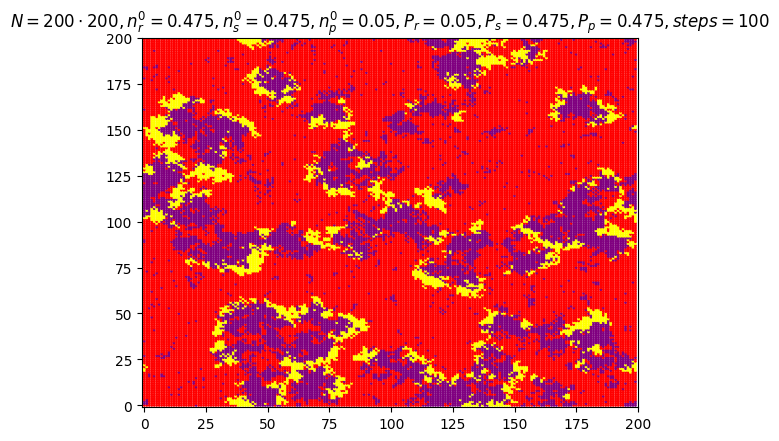

In [22]:
draw_grid(
    model4_100.grid,
    agent_portrayal,
    title=build_title(params=model_params4, steps=100)
    )

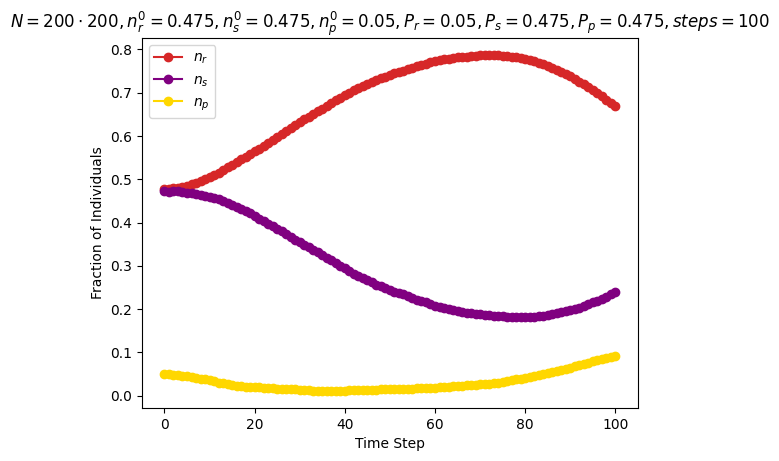

In [23]:
line_plot(
    model4_100,
    title=build_title(params=model_params4, steps=100)
)

Running a simulation and plotting the grid after 300 steps and the evolution of the species proportions over time.

In [24]:
model4_300 = RSPRandAct(**model_params4)
for i in range(300):
    model4_300.step()

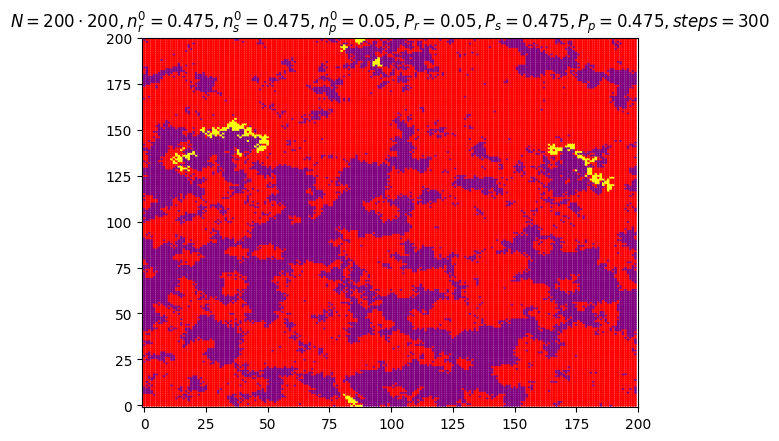

In [25]:
draw_grid(
    model4_300.grid,
    agent_portrayal,
    title=build_title(params=model_params4, steps=300)
    )

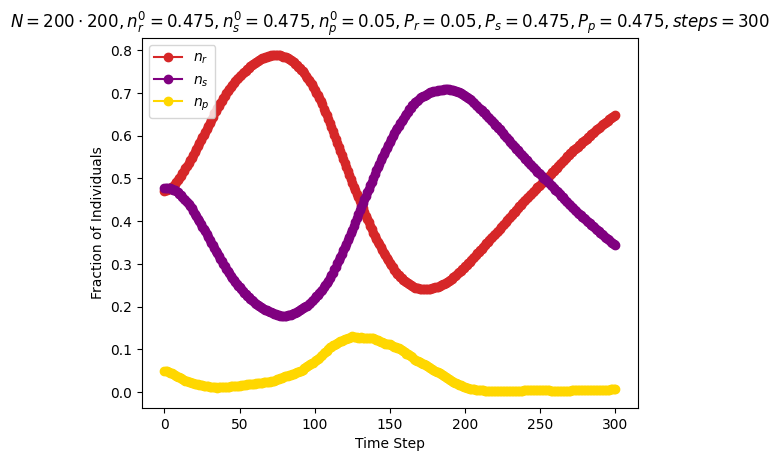

In [26]:
line_plot(
    model4_300,
    title=build_title(params=model_params4, steps=300)
)

If species R invasion rate is much smaller than the other two, then species R and S have similar patchy distributions, with species P persisting in fast-moving thin fronts.

Performing simulations for a range of invasion probabilities chosen to sum to unity, initializing the population densities with equal proportions:

In [ ]:
# defining a grid of points for invasion probabilities
R, S = np.mgrid[0:1:10j, 0:1:10j]
R, S = R.ravel(), S.ravel()
P = 1 - R - S
I = np.array([R, S, P]).T
# keeping only invasion probabilities greater than 0.01
I = I[np.all(I > 0.01, axis=1)]
R = I[:, 0]
S = I[:, 1]
P = I[:, 2]
# parameters for the batch run
params_batch = {
    "height": 100,
    "width": 100,
    "color_map": color_map,
    "n_species": 3,
    "init0": 0.33,
    "init1": 0.33,
    "init2": 0.33,
    "init3": 0,
    "init4": 0,
    "invrate3": 0,
    "invrate4": 0,
}
# dataframe to store the results
batch_results_df = pd.DataFrame()

# iterating over the invasion probabilities
for i, (Pr, Ps, Pp) in enumerate(I):
    params_batch['invrate0'] = Pr
    params_batch['invrate1'] = Ps
    params_batch['invrate2'] = Pp
    print(f"[{i+1}/{len(I)}] Running model with parameters: {params_batch}")
    # simulating with the current invasion probabilities
    results = mesa.batch_run(
        RSPRandAct,
        params_batch,
        iterations=1,
        max_steps=300,
        number_processes=1,
        data_collection_period=1,
        display_progress=True,
    )
    # concatenating the results of the current simulation
    curr_results_df = pd.DataFrame(results)
    curr_results_df['simulation_id'] = i
    tot_individuals = curr_results_df[0] + curr_results_df[1] + curr_results_df[2]
    curr_results_df.rename(columns={0: 'individuals_r', 1: 'individuals_s', 2: 'individuals_p'}, inplace=True)
    curr_results_df['$n_r$'] = curr_results_df['individuals_r'] / tot_individuals
    curr_results_df['$n_s$'] = curr_results_df['individuals_s'] / tot_individuals
    curr_results_df['$n_p$'] = curr_results_df['individuals_p'] / tot_individuals
    batch_results_df = pd.concat([batch_results_df, curr_results_df])

# saving the results to a csv file
batch_results_df.to_csv("./results/lattice_simulations_results.csv", index=False)
batch_results_df

In [28]:
batch_results_df = pd.read_csv("./results/lattice_simulations_results.csv") # TODO: remove

Plotting a countour summarizing the results of 28 simulations that are each 300 epochs long on a square lattice with $N=100\cdot 100$ sites  and showing the mean value of $n_s$ over the final 100 epochs of each model run. Data are only shown for the region that had all its invasion probabilities greater than 0.01 as outside this region, with such a small invasion probability, the grid is too small to stabilize fluctuations in the population densities.

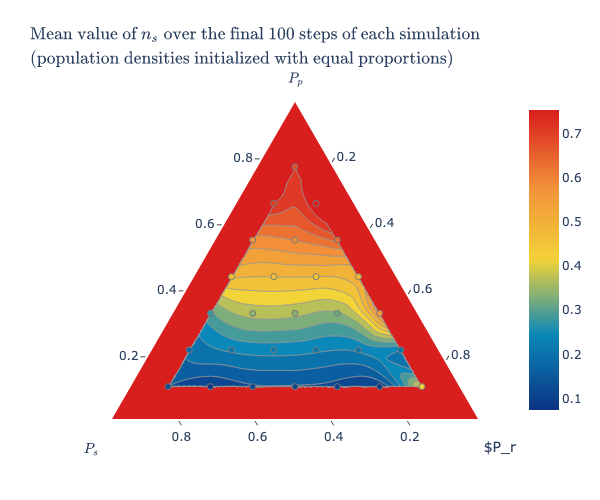

In [29]:
ns_final = np.array(batch_results_df[batch_results_df['Step']>200].groupby('simulation_id')['$n_s$'].mean())
fig = ff.create_ternary_contour(
    np.array([I.T[2], I.T[1], I.T[0]]),
    ns_final,
    pole_labels=['$P_p$', '$P_s$', '$P_r'],
    interp_mode='ilr',
    ncontours=15,
    colorscale='Portland',
    coloring=None,
    showmarkers=True,
    showscale=True,
    title=r'$\text{Mean value of }n_s\text{ over the final 100 steps of each simulation}\\\text{(population densities initialized with equal proportions)}$',
)
fig.update_layout(width=600)
fig.show('png')

The value of $n_s$ at the mean-field fixed point varies linearly from the base of the triangle to the top. Deviations from the mean-field approximation are seen toward the corners of the triangle, but $n_s$ still rises with decreasing $P_s$.

Despite the large clumps that may develop when the invasion rates are unequal, the population densities remain close to the fixed point of the mean-field equations over much of the parameter space of the invasion probabilities and the paradox, that the most aggressive species does not have the largest population, still holds.

Let's define the parameters to perform a simulation of a system with 3 species in which the invasion rate of a species (species R) is increased over time (`increase_rate=True`), on a square lattice with $N=200\cdot 200$ sites and initial invasion rates $P_r=0.05, P_s=0.5, P_p=0.3$. The grid is initialized with the sites being randomly assigned to each of the three species in fixed-point proportions ($n_r=0.5, n_s=0.3, n_p=0.05$).

In [30]:
model_params_increase_rate = {
    "height": 200,
    "width": 200,
    "color_map": color_map,
    "n_species": 3,
    "init0": 0.5,
    "init1": 0.3,
    "init2": 0.05,
    "init3": 0,
    "init4": 0,
    "invrate0": 0.05,
    "invrate1": 0.5,
    "invrate2": 0.3,
    "invrate3": 0,
    "invrate4": 0,
    "increase_rate": True
}

In [31]:
page = JupyterViz(
    RSPRandAct,
    model_params_increase_rate,
    measures=[line_plot, plot_rate_species0],
    agent_portrayal=agent_portrayal,
)
page

Cannot show ipywidgets in text

In [32]:
model5 = RSPRandAct(**model_params_increase_rate)
for i in range(300):
    model5.step()

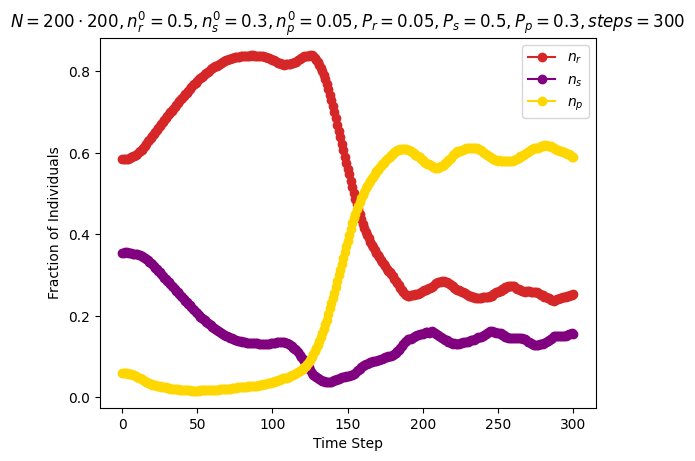

In [33]:
line_plot(
    model5,
    title=build_title(params=model_params_increase_rate, steps=300)
)

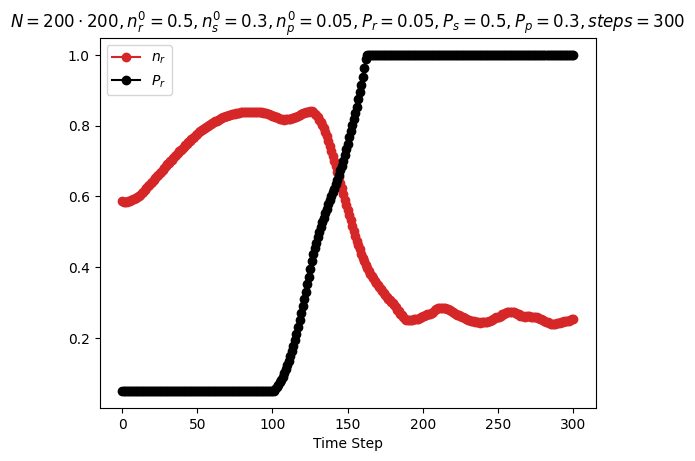

In [36]:
plot_rate_species0(
    model5,
    title=build_title(params=model_params_increase_rate, steps=300)
)

An increase in the invasion rate of species R results in a decrease of its population.